# Actor-Critic

##### Imports

In [1]:
import torch
from torch import nn, optim
from tqdm import tqdm
from kilroyplot.plot import plt

## Rewards

Random rewards from $U(-1, 1)$

In [2]:
n_choices = 10

In [3]:
rewards = torch.distributions.uniform.Uniform(-1, 1).sample((n_choices,)) 
rewards

tensor([ 0.9123,  0.1474,  0.6714,  0.5168, -0.3994, -0.6246, -0.2064,  0.3887,
         0.0846, -0.4759])

## Model

In [4]:
class Actor(nn.Module):
    """Predicts probabilities of each action being the best."""
    
    def __init__(self, n_out, n_hidden=10):
        super().__init__()
        self.x = torch.ones(1)
        self.layers = nn.Sequential(
            nn.Linear(1, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_out),
            nn.Softmax(-1)
        )

    def forward(self):
        return self.layers(self.x)

In [5]:
class Critic(nn.Module):
    """Predicts reward for given action."""
    
    def __init__(self, n_in, n_hidden=10):
        super().__init__()
        self.x = torch.ones(n_hidden)
        self.layers = nn.Sequential(
            nn.Linear(n_in, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, 1)
        )

    def forward(self, x):
        return self.layers(x)

##### Utilities

In [6]:
class Sampler:
    """Samples values from categorical distribution."""
    
    def __init__(self, weights):
        self.sampler = torch.distributions.categorical.Categorical(weights)
        
    def sample(self, n=1):
        return  self.sampler.sample((n,))

In [7]:
class OneHotEncoder:
    """One-hot encodes actions."""
    
    def __init__(self, n):
        self.n = n
        
    def encode(self, x):
        return nn.functional.one_hot(x, self.n)

## Learning

Critic learns rewards for actions generated from actor by supervised learning. Actor learns to give higher probability to actions rated high by critic by Policy Gradients.

The assumption is that evaluating real rewards is costly, so critic should learn to evaluate as quickly as possible. Then we can use critic to evaluate actions sampled from actor and teach actor using that.

In [8]:
actor = Actor(n_choices)
critic = Critic(n_choices)

In [9]:
encoder = OneHotEncoder(n_choices)

In [10]:
actor_optimizer = optim.Adam(actor.parameters(), lr=0.001)
critic_optimizer = optim.Adam(critic.parameters(), lr=0.005)

In [11]:
epochs = 1000
actor_iters = 10000
critic_iters = 10

In [12]:
def train_critic(actor, critic, iters, optimizer, encoder, rewards):
    optimizer.zero_grad()
    choice = Sampler(actor()).sample(iters)
    x = encoder.encode(choice)
    pred_reward = critic(x.float())
    real_reward = rewards[choice].unsqueeze(-1)
    loss = nn.MSELoss()(pred_reward, real_reward)
    loss.backward()
    optimizer.step()
    return loss

def train_actor(actor, critic, iters, optimizer, encoder):
    optimizer.zero_grad()
    probs = actor()
    choice = Sampler(probs).sample(iters)
    x = encoder.encode(choice)
    reward = critic(x.float())
    loss = -(reward * torch.log(probs[choice].unsqueeze(-1))).mean()
    loss.backward()
    optimizer.step()
    return loss, reward

In [13]:
critic_losses = []
actor_losses = []
actor_rewards = []

for _ in tqdm(range(epochs)):
    loss = train_critic(actor, critic, critic_iters, critic_optimizer, encoder, rewards)
    critic_losses.append(loss.item())
    
    loss, reward = train_actor(actor, critic, actor_iters, actor_optimizer, encoder)
    actor_losses.append(loss.item())
    actor_rewards.append(reward.mean().item())

100%|██████████| 1000/1000 [00:05<00:00, 167.79it/s]


## Results

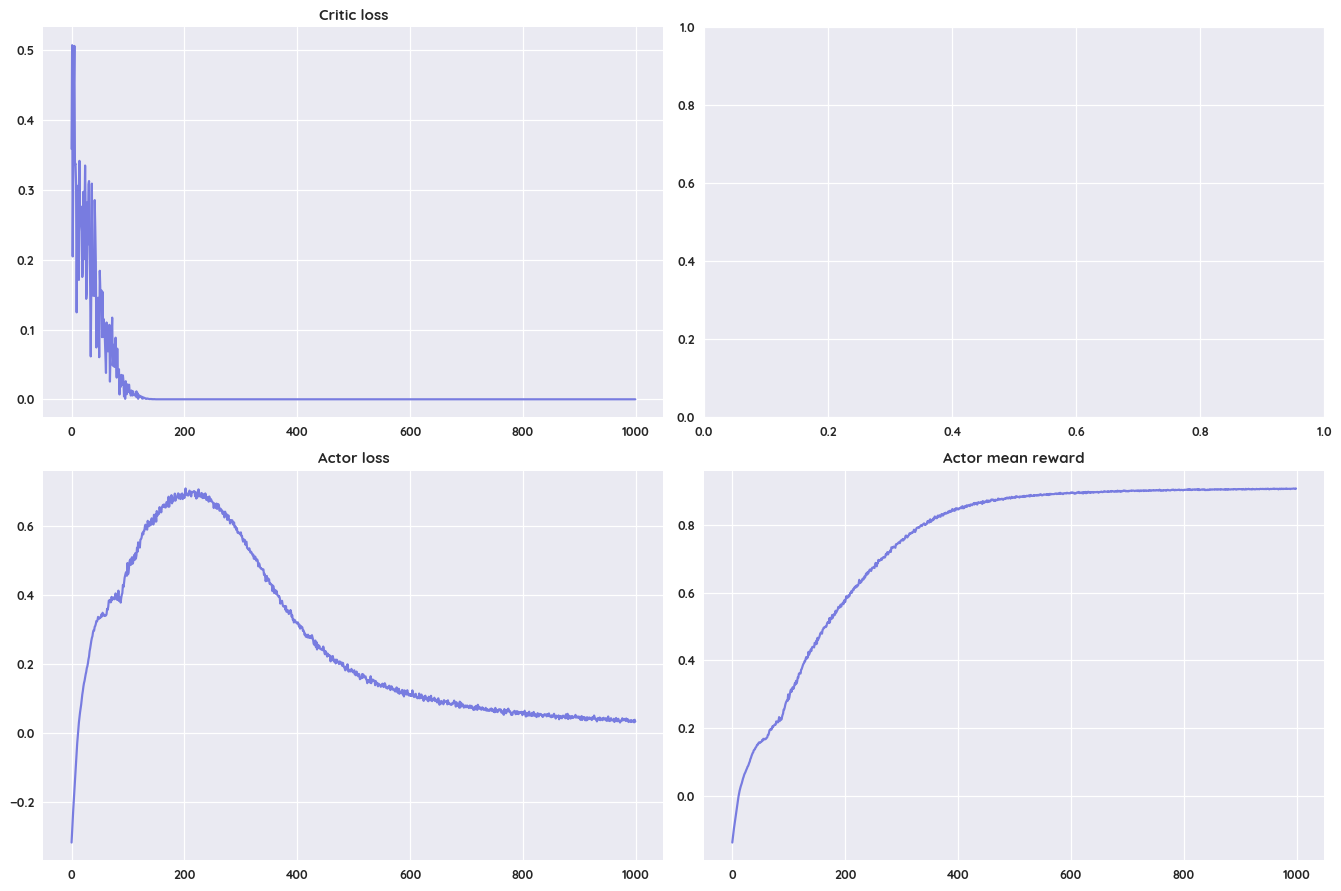

In [14]:
_, axs = plt.subplots(2, 2, figsize=(15, 10))
axs[0][0].plot(critic_losses)
axs[0][0].set_title("Critic loss")
axs[1][0].plot(actor_losses)
axs[1][0].set_title("Actor loss")
axs[1][1].plot(actor_rewards)
axs[1][1].set_title("Actor mean reward")
plt.tight_layout()

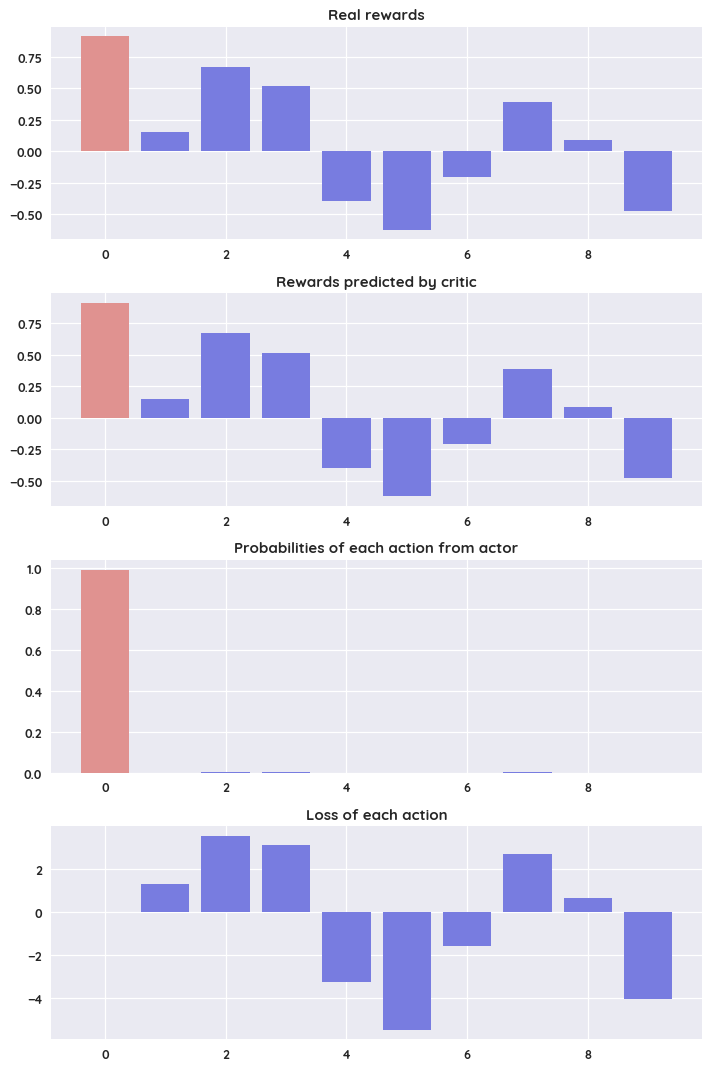

In [15]:
color=['C1' if i == actor().argmax() else 'C0' for i in range(n_choices)]
_, axs = plt.subplots(4, 1, figsize=(8, 12))

axs[0].bar(range(n_choices), rewards, color=color)
axs[0].set_title("Real rewards")
choice = torch.arange(n_choices)

reward = critic(encoder.encode(choice).float())
axs[1].bar(range(n_choices), reward.flatten().detach().numpy(), color=color)
axs[1].set_title("Rewards predicted by critic")

probs = actor()
axs[2].bar(range(n_choices), probs.detach().numpy(), color=color)
axs[2].set_title("Probabilities of each action from actor")

loss = -(reward * torch.log(probs[choice].unsqueeze(-1)))
axs[3].bar(range(n_choices), loss.flatten().detach().numpy(), color=color)
axs[3].set_title("Loss of each action")

plt.tight_layout()